In [1]:
from utils import get_percent_chosen
import pandas as pd
from glob import glob
import os
import numpy as np

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = 'model_scores/deberta_v3_large/shp'

In [27]:
original = pd.read_csv(os.path.join(base_dir, 'english_original_scores.csv'))
get_percent_chosen(original)

0.5498373828199732

In [76]:
original_df = pd.read_csv('data/shp/english_original.csv').fillna('')
original['domain'] = original_df['domain']

In [89]:
res = []
for domain, subset in original.groupby('domain'):
    score = get_percent_chosen(subset[['chosen', 'rejected']])
    res.append({'domain' : domain, '# examples' : subset.shape[0], 'score':round(score*100,2) })
res = pd.DataFrame(res).sort_values('score')
res

,domain,# examples,score
10,askphysics_test,338,48.52
17,legaladvice_test,657,49.92
7,askhistorians_test,98,50.00
6,askengineers_test,1456,52.13
0,askacademia_test,880,52.27
15,changemyview_test,1120,52.32
8,askhr_test,210,54.29
16,explainlikeimfive_test,715,54.97
4,askculinary_test,1470,56.60
2,askbaking_test,784,56.63


In [77]:
from transformers import AutoTokenizer
from collections import defaultdict
tokenizer = AutoTokenizer.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2")
perc_unique = {}
for text_type in ['prompt', 'chosen', 'rejected']:
    all_token_counts = {}
    total_num_tokens = defaultdict(int)
    for domain, subset in original_df.groupby('domain'):
        token_cts = defaultdict(int)
        for i in range(len(subset)):
            inp_ids = tokenizer(subset[text_type].iloc[i], return_tensors='np').input_ids[0]
            total_num_tokens[domain] += len(inp_ids)
            unique_vals, cts = np.unique(inp_ids, return_counts=True)
            for v,c in zip(unique_vals, cts):
                token_cts[v] += c
        all_token_counts[domain] = token_cts

    unique_tokens = {}
    for domain in all_token_counts:
        oth_tokens = []
        for oth_domain in all_token_counts:
            if domain == oth_domain:
                continue
            oth_tokens.extend(all_token_counts[oth_domain].keys())
        oth_tokens = list(set(oth_tokens))
        unique_tokens[domain] = list(set(all_token_counts[domain]) - set(oth_tokens))
    
    num_unique = {}
    for domain, unique_token_id in unique_tokens.items():
        ct = 0
        for v in unique_token_id:
            ct += all_token_counts[domain][v]
        num_unique[domain] = ct
    for k,v in num_unique.items():
        num_unique[k] = v / total_num_tokens[k]
    perc_unique[text_type] = num_unique
pd.DataFrame(perc_unique)

,prompt,chosen,rejected
askacademia_test,0.039277,0.022817,0.028321
askanthropology_test,0.067930,0.041452,0.052015
askbaking_test,0.054001,0.032688,0.042232
askcarguys_test,0.048609,0.029468,0.034621
askculinary_test,0.073857,0.052664,0.061555
askdocs_test,0.039678,0.032842,0.037197
askengineers_test,0.041684,0.024523,0.029762
askhistorians_test,0.069124,0.059232,0.059424
askhr_test,0.029199,0.012256,0.017045
askphilosophy_test,0.051384,0.042945,0.059977


In [99]:
perc = (pd.DataFrame(perc_unique)*100).round(2)
perc['score'] = perc.index.map(res.set_index('domain').to_dict()['score'])
perc.sort_values('score')

,prompt,chosen,rejected,score
askphysics_test,4.61,2.35,2.83,48.52
legaladvice_test,3.74,2.38,3.59,49.92
askhistorians_test,6.91,5.92,5.94,50.00
askengineers_test,4.17,2.45,2.98,52.13
askacademia_test,3.93,2.28,2.83,52.27
changemyview_test,6.56,2.81,3.99,52.32
askhr_test,2.92,1.23,1.70,54.29
explainlikeimfive_test,4.56,3.39,4.03,54.97
askculinary_test,7.39,5.27,6.16,56.60
askbaking_test,5.40,3.27,4.22,56.63


Text(0, 0.5, 'Accuracy')

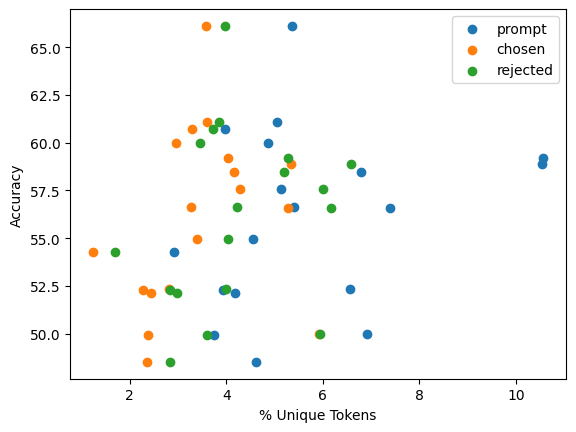

In [98]:
import matplotlib.pyplot as plt
for text_type in ['prompt', 'chosen', 'rejected']:
    plt.scatter(perc[text_type], perc['score'], label=text_type)
plt.legend()
plt.xlabel('% Unique Tokens')
plt.ylabel('Accuracy')

In [85]:
res.set_index('domain').to_dict()['score']

{'askphysics_test': 48.52,
 'legaladvice_test': 49.92,
 'askhistorians_test': 50.0,
 'askengineers_test': 52.13,
 'askacademia_test': 52.27,
 'changemyview_test': 52.32,
 'askhr_test': 54.29,
 'explainlikeimfive_test': 54.97,
 'askculinary_test': 56.6,
 'askbaking_test': 56.63,
 'askphilosophy_test': 57.58,
 'askanthropology_test': 58.46,
 'asksciencefiction_test': 58.88,
 'askscience_test': 59.2,
 'askcarguys_test': 60.0,
 'askdocs_test': 60.74,
 'asksocialscience_test': 61.11,
 'askvet_test': 66.12}

In [69]:
for k,v in unique_tokens.items():
    print(k, len(v))

askacademia_test 701
askanthropology_test 323
askbaking_test 412
askcarguys_test 109
askculinary_test 1083
askdocs_test 427
askengineers_test 911
askhistorians_test 320
askhr_test 231
askphilosophy_test 485
askphysics_test 260
askscience_test 615
asksciencefiction_test 1216
asksocialscience_test 236
askvet_test 227
changemyview_test 2505
explainlikeimfive_test 373
legaladvice_test 1114


In [61]:
all_token_counts['askacademia_test']

defaultdict(int,
            {1: 880,
             2: 880,
             260: 6042,
             261: 5051,
             262: 3772,
             263: 3409,
             264: 4745,
             265: 2174,
             266: 3501,
             267: 1971,
             268: 1380,
             269: 1387,
             270: 1506,
             271: 1083,
             274: 1072,
             275: 904,
             276: 588,
             277: 1415,
             279: 225,
             281: 747,
             285: 963,
             287: 867,
             288: 459,
             293: 181,
             294: 755,
             295: 421,
             299: 393,
             302: 1954,
             320: 683,
             337: 545,
             340: 364,
             345: 34,
             346: 122,
             394: 165,
             395: 203,
             413: 173,
             419: 40,
             423: 69,
             429: 21,
             452: 38,
             492: 67,
             523: 23,
             

In [60]:
all_token_counts['askanthropology_test']

defaultdict(int,
            {1: 130,
             2: 130,
             260: 419,
             261: 374,
             263: 261,
             264: 293,
             265: 297,
             266: 238,
             268: 164,
             269: 112,
             270: 100,
             272: 212,
             273: 311,
             278: 133,
             280: 193,
             286: 52,
             289: 101,
             299: 52,
             302: 280,
             306: 20,
             308: 45,
             314: 36,
             335: 11,
             343: 55,
             352: 24,
             361: 20,
             393: 8,
             401: 9,
             415: 14,
             422: 7,
             429: 5,
             431: 27,
             451: 4,
             491: 4,
             596: 5,
             738: 16,
             853: 1,
             857: 31,
             1019: 7,
             1024: 6,
             1384: 1,
             1454: 7,
             1539: 1,
             1551: 14,
         

In [29]:
get_percent_chosen(original)

TypeError: '>' not supported between instances of 'str' and 'float'

In [24]:
original_df = pd.read_csv('data/shp/english_original.csv')
import random
for i, r in enumerate(random.sample(range(len(original_df)), 5)):
    print(r)
    for c in original_df.columns:
        print(f'------{c}-------')
        print(original_df.iloc[r][c])
    print()

5614
------prompt-------
High school Philosophy Club I am a high school teacher and I started a philosophy club this past school year. We spent the year basically bouncing around every philosophical topic I could think of and touching them briefly. But I want to do something different for this next year. Maybe some sort of curriculum as a more organized way to go at philosophy. I could also take them through a book but I have no idea where to start.   I would love to hear thoughts/suggestions. Thank you in advance!
------chosen-------
It's amazing that you've stated a philosophy club in high-school. Kudos for that!  I agree with other suggestions regarding making the students curious. But I would also suggest that you maybe also start with basic critical thinking stuff like basic logic, argumentation etc. These tools will help the students a lot in the long run.
------rejected-------
I’m not sure if others would find this a good choice, but one of the first books I read of philosophy w

In [8]:
original

,chosen,rejected
0,-1.272269,-2.154334
1,-1.272269,-1.828584
2,-1.272269,-1.570738
3,-2.154334,-1.828584
4,-2.692477,-0.142264
...,...,...
10449,-5.831630,-2.895151
10450,-2.032893,-3.652580
10451,0.507388,-1.877726
10452,0.507388,-4.250148


In [5]:
langs =[]
for l in os.listdir(base_dir):
    if '.csv' not in l:
        langs.append(l)
langs

['german', 'hindi', 'french', 'russian', 'spanish']

In [6]:
res = {}
for lang in langs:
    paths = {
        'translated prompt + translated response' : f'{lang}_prompt_{lang}_response.csv',
        'translated prompt + english response' : f'{lang}_prompt_english_response.csv',
        'english prompt + translated response' : f'english_prompt_{lang}_response.csv',
        'translated back' : 'translated_back_scores.csv'
    }
    dfs = {k: pd.read_csv(os.path.join(base_dir, lang, v)) for k,v in paths.items()}
    scores = {k: get_percent_chosen(v) for k,v in dfs.items()}
    res[lang] = scores

In [7]:
score_df = pd.DataFrame(res)
(score_df * 100).round(2)

,german,hindi,french,russian,spanish
translated prompt + translated response,48.27,38.72,49.20,44.77,49.80
translated prompt + english response,54.06,55.89,54.30,54.79,54.50
english prompt + translated response,50.77,44.44,51.43,47.64,52.43
translated back,52.31,41.38,51.96,49.67,52.11


In [30]:
dfs['translated back']

,chosen,rejected
0,-6.133464,-0.634098
1,-0.634098,-2.863509
2,-6.133464,-2.863509
3,-0.634098,-5.452024
4,-5.452024,-2.863509
...,...,...
83797,6.708595,6.465341
83798,-5.159493,-5.567867
83799,-4.866924,-5.918250
83800,5.612156,2.923607
